# Analytic Deep Prior

The so called deep image prior (DIP) has been recently introduced as a machine learning approach for some tasks in image processing (Ulyanov et al. 2017). 

Usually, such machine learning approaches utilize large sets of training data, hence, it was somewhat surprising that deep image priors are based on a single data point $y^\delta$.

In order to solve the inverse problem $Ax=y^\delta$, the task of DIP is to train a network $\varphi_W(z)$ with parameters $W$ by minimizing the simple loss function $\| A \varphi_W(z) - y^\delta \|^2$. The minimization is with respect to $W,$ the input  $z$ is kept fixed. After training, the solution of the problem is approximated by $\hat x = \varphi_W(z).$

For the analytical deep prior we consider the particular architecture of a fully connected feedforward iterative network with $L$ identical layers.


## Definition 
Consider a fully connected neural network $\varphi_W$ with $L$  layers, whose activation function is a proximal mapping $\mathrm{prox}_{\alpha \lambda R}$ with respect to a convex functional $R:X \rightarrow I\!\!R$, i.e

$\varphi_W(z) = x^L,$
    
where

$x^{k+1} =\mathrm{prox}_{\alpha \lambda R} (Wx^k + b)$

and $x_0 = z.$ Further assume that $W$ can be decomposed as $W=I-B^*B$ with a bounded operator $B:X \rightarrow W$ and that the bias satisfies $b= \lambda B^*y^\delta$. Then the output of the network is the $L$-iterative of the Proximal Gradient (PG) method for minimizing the Tikhonov functional

$J_B(x)= \frac{1}{2} \| B x - y^\delta\|^2  + \alpha R(x).$ 

Assume that a unique minimizer $x(B) = \mathrm{argmin\ } J_B(x)$ exists. We call this setting an **analytic deep prior** if $W$, resp. $B$, is trained from a single data point $y^\delta$ by gradient descent applied to \begin{equation}
    \min_B\|Ax(B) - y^\delta\|^2.
\end{equation}



## Implementation

In order to guarantee that the output of the network $x(B)$ actually converges to $\mathrm{arg\,min\,} J_B$, the network should in principle have thousands of layers, because of the slow convergence of the PG method. 

This is prohibitive from the implementation point of view. During the training iterations, in which we update $B$, we therefore consider only a reduced network with a small number, $L=10,$ of layers but we set the input to be the network's output after the previous iteration. This is equivalent to adding $L$ new identical layers, with ${W_k = I- \lambda B_k^TB_k}$ and ${b_k=\lambda B_k^T y^\delta}$, at the end of an implicit network which is growing by $L$ layers at a time. After the $k$-th iteration, we have implicitly created a network that has $(k+1)L$ layers. However, in the next iteration $B$ is updated considering only back-propagation over the last $L$ layers.

![title](network.png)

In [1]:
import tensorflow as tf
import warnings
from solvers import tikhonov
import numpy as np

warnings.filterwarnings("ignore")

def analytic_deep_prior(A, z, y_delta, alpha, lam=1.0, pen='l2', iters=20000, layers=10, lr=0.01, 
                        train_alpha=False, train_lambda=False, warm=True, unroll_fista=False, verbose=1,
                        callback=None, callback_interval=1, basis=None):
    if basis is None:
        basis_tensor = tf.constant(np.eye(A.shape[0]), dtype=tf.float64)
    else:
        basis_tensor = tf.constant(basis, dtype=tf.float64)

    x_shape = z.shape
    n = x_shape[0]

    y_tensor = tf.constant(y_delta, dtype=tf.float64)

    A_tensor = tf.constant(A, dtype=tf.float64)
    B_tensor_A = tf.Variable(A, dtype=tf.float64)
    B_tensor = tf.matmul(B_tensor_A, basis_tensor)
    
    if train_alpha:
        alpha_tensor = tf.Variable(np.sqrt(alpha), dtype=tf.float64)
        alpha_tensor = tf.square(alpha_tensor)
    else:
        alpha_tensor = tf.constant(alpha, dtype=tf.float64)

    if train_lambda:
        lambda_tensor = tf.Variable(np.sqrt(lam), dtype=tf.float64)
        lambda_tensor = tf.square(lambda_tensor)
    else:
        lambda_tensor = tf.constant(lam, dtype=tf.float64)

    z_holder = tf.placeholder(tf.float64, shape=x_shape)

    W = tf.eye(n, dtype=tf.float64) - lambda_tensor * tf.matmul(tf.transpose(B_tensor), B_tensor)
    b = lambda_tensor * tf.matmul(tf.transpose(B_tensor), y_tensor)

    def prox(x):
        eps = alpha_tensor * lambda_tensor
        if pen is 'l1':
            return tf.sign(x) * tf.nn.relu(tf.abs(x) - eps)
        elif pen is 'l2':
            return x / (1 + eps)
        else:
            return x

    x_tensor = z_holder

    if unroll_fista:
        # layers correspond to FISTA iterations
        s_tensor = x_tensor
        tk = 1
        for i in range(layers):
            x_tensor_prev = x_tensor
            x_tensor = tf.matmul(W, s_tensor) + b
            x_tensor = prox(x_tensor)
            t_prev = tk
            tk = (1 + np.sqrt(1 + 4 * tk * tk)) / 2
            s_tensor = x_tensor + (x_tensor - x_tensor_prev) * (t_prev - 1) / tk
    else:
        # layers correspond to ISTA iterations
        for i in range(layers):
            x_tensor = tf.matmul(W, x_tensor) + b
            x_tensor = prox(x_tensor)

    residual_tensor = tf.reduce_sum(tf.square(y_tensor - tf.matmul(A_tensor, tf.matmul(basis_tensor, x_tensor))))
    opt = tf.train.GradientDescentOptimizer(lr).minimize(residual_tensor)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    x = None
    for i in range(iters):
        x, res, lam, alpha, B = sess.run([x_tensor, residual_tensor, lambda_tensor, alpha_tensor, B_tensor_A],
                                         {z_holder: z})
        sess.run([opt], {z_holder: z})
        
        if verbose and i % callback_interval == 0:
            print('iter={}, residual={}     '.format(i, res), end="\r")
            if callback is not None:
                callback(x=x, res=res, pen=penalty(x, pen), lam=lam, alpha=alpha, B=B)
        if warm:
            z = x
    return x

/opt/python-3.5.5/lib/python3.5/site-packages/h5py-2.8.0-py3.5-linux-x86_64.egg/h5py/__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.8.16, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


## Numerical Example
We now use the analytic deep prior approach for solving an inverse problem with the following integration operator $A:L^2\left(\left[0,1\right]\right)\rightarrow L^2\left(\left[0,1\right]\right)$
\begin{equation}
\label{integration_operator}
\left(Ax\right)(t) = \int_0^{t}x(s) ds.
\end{equation}
$A$ is linear and compact, hence  the inverse problem is ill-posed. Discretizing $A$ yields the matrix:

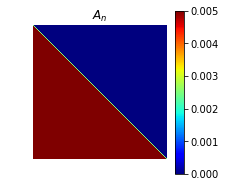

In [2]:
%matplotlib inline

from misc import get_operator
from plot_tools import *
import matplotlib.pyplot as plt

n=200
A, L, pts = get_operator('integral', n)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1)
plot_matrix(ax, A, '$A_n$', make_colorbar=True)

# plt.savefig('operator_matrix.pdf')

### Example (l2-regularization)
We choose $x^\dagger \in \mathbb{R}^n$ to be one of its singular vectors $u$. Then we set the noisy data ${y^\delta = A_n x^\dagger + \tau}$ with ${\tau \sim \mathcal{N}(0,\sigma^2\mathbb{1}_n)}$ and $\sigma$ equals $10\%$ of the largest coefficient of $y^\dagger$. 



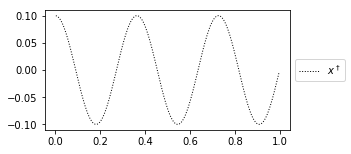

In [3]:
u, s, v = np.linalg.svd(A)
x_true = v[5].reshape(-1, 1)

fig = plt.figure(figsize=(5.5, 2.2))
ax = fig.add_subplot(1, 1, 1)
plot_true_solution(ax, pts, x_true)

# plt.savefig('x_true_l2.pdf')

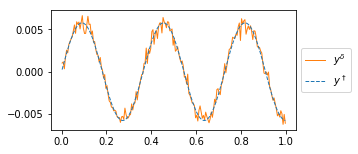

In [4]:
np.random.seed(10)

y_true = np.dot(A, x_true)
delta = 0.1 * np.max(np.abs(y_true))
y_delta = y_true + np.random.normal(0, delta, size=y_true.shape)

fig = plt.figure(figsize=(5.5, 2.2))
ax = fig.add_subplot(1, 1, 1)
plot_data(ax, pts, y_true, y_delta)

# plt.savefig('y_delta_l2.pdf')

We aim to recover $x^\dagger$ from $y^\delta$ considering the setting established in Def. 3.1 from the paper, for ${R(\cdot)=\frac{1}{2}\|\cdot\|^2}$ and a fixed value of $\alpha$. That means the solution $x$ is parametrized by the weight matrix $B$ of the network, i.e. $x(B) = \varphi_W(z)$ with $W = I-B^TB$ and $z \in \mathbb{R}^n$ some arbitrary fixed input. 

Solving the inverse problem is now equivalent to training the network $\varphi_W(z)$, i.e. finding optimal $B$, to minimize the loss function $\| A \varphi_W(z) - y^\delta \|^2$ for the single data point $(z, y^\delta)$. 

Afterwards, the reconstruction is obtained by computing $x(B)=\mathrm{argmin\ } J_B$.

In order to properly update $B$ by back-propagation, the network was implemented ensuring that the output $x(B)$ actually converges to $\mathrm{argmin\ } J_B$.

#### Using a fixed value of $\alpha$

In [5]:
from misc import Callback
from solvers import tikhonov_l2

network_err = []

def fixed_alpha_l2(alpha, lr, iters):
    z = np.random.normal(0, 0.1, size=x_true.shape)
    print('alpha={}, lr={}, iter={}'.format(alpha, lr, iters))
    callback = Callback(x_true=x_true)
    
    x_deep = analytic_deep_prior(A, z=z, y_delta=y_delta, alpha=alpha, lam=1/L, train_alpha=False, iters=iters, lr=lr,
                                 callback=callback, callback_interval=1)
    
    err = list([penalty(callback.x_seq[i] - tikhonov_l2(callback.B_seq[i], y_delta, alpha)) for i in range(len(callback.B_seq))])
    x_tik = tikhonov_l2(A, y_delta, alpha)
    
    print('standard tikhonov error: {}'.format(penalty(x_tik - x_true)))
    print('analytic deep prior error: {}'.format(penalty(x_deep - x_true)))
    
    plot_summary_fixed(pts, A, x_true=x_true, x_seq=callback.x_seq, x_ref=x_tik, B_seq=callback.B_seq, alpha=alpha)
    
    return err

alpha=0.02, lr=0.05, iter=6000
standard tikhonov error: 0.7368794947441256   
analytic deep prior error: 0.6337419917702479


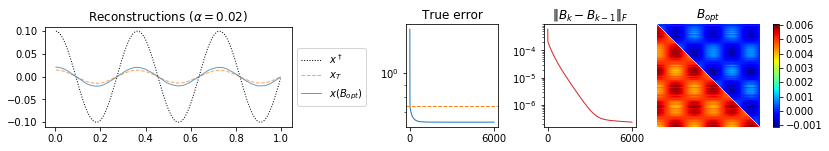

In [6]:
network_err += [fixed_alpha_l2(alpha=2.0e-2, lr=0.05, iters=6000)]
# plt.savefig('fixed_alpha_l2_1.pdf')

alpha=0.0015, lr=0.05, iter=6000
standard tikhonov error: 0.10201549997035514   
analytic deep prior error: 0.06732694888631241


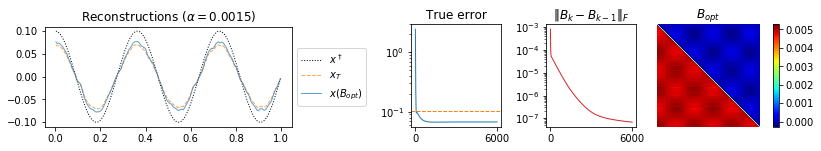

In [7]:
network_err += [fixed_alpha_l2(alpha=1.5e-3, lr=0.05, iters=6000)]
# plt.savefig('fixed_alpha_l2_2.pdf')

alpha=0.0011, lr=0.05, iter=6000
standard tikhonov error: 0.06743230204075128   
analytic deep prior error: 0.024232559253669267


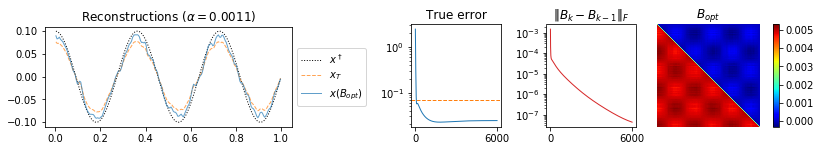

In [8]:
network_err += [fixed_alpha_l2(alpha=1.1e-3, lr=0.05, iters=6000)]
# plt.savefig('fixed_alpha_l2_3.pdf')

Let $x_k$ be the output of this implicit network after iteration $k$. In order to properly update $B$ by the back-propagation, we need $x_k$ to be a good approximation of $x(B_k)$ . We checked empirically that $x_k \rightarrow x(B_k)$ when $k\rightarrow\infty$ by evaluating ${x(B_k)=(B_k^TB_k + \alpha I)^{-1}B_k^T y^\delta}$ and computing $\Vert x_k - x(B_k) \Vert^2$ at each iteration. As it can be observed, after $k>100$ the error is considerably low.

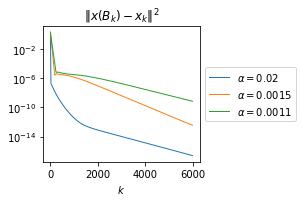

In [9]:
fig = plt.figure(figsize=(4.0, 2.5))
ax = fig.add_subplot(1, 1, 1)

plot_network_convergence(ax, network_err, alphas=[2e-2, 1.5e-3, 1.1e-3])    
# plt.savefig('network_convergence.pdf')

#### Using an adaptive value of $\alpha$

Finding the optimal regularization parameter $\alpha$ usually involves finding reconstructions for many different values of it. In our case, that would mean to retrain the network each time, which would amount to high computational costs. 

This motivates an adaptive choice of $\alpha$ during the optimization, which could be achieved by letting $\alpha$ to be also a trainable weight of the network.


In [10]:
def adaptive_alpha_l2(alpha0, lr, iters):
#     z = np.random.normal(0, 0.1, size=x_true.shape)
    z = np.zeros(shape=x_true.shape)
    print('alpha0={},lr={},iter={}'.format(alpha0, lr, iters))

    callback = Callback(x_true=x_true)
    analytic_deep_prior(A, z=z, y_delta=y_delta, alpha=alpha0, lam=1/L, train_alpha=True, iters=iters, lr=lr,
                        callback=callback, callback_interval=1)
    return callback
    
def plot_adaptive_alpha_l2(summary, alpha0, x_ref, index):
    print('standard tikhonov error: {}'.format(penalty(x_ref - x_true)))
    print('analytic deep prior error: {}'.format(penalty(summary.x_seq[index] - x_true)))
    
    plot_summary_adaptive(pts, A, x_true=x_true, x_seq=summary.x_seq, B_seq=summary.B_seq, alpha0=alpha0,
                          alpha_seq=summary.alpha_seq, ref_seq=[x_ref]*len(summary.alpha_seq), index=index)

In [11]:
summary1 = adaptive_alpha_l2(alpha0=1e-1, lr=0.05, iters=6000)

alpha0=0.1,lr=0.05,iter=6000


standard tikhonov error: 0.050315748133037824
analytic deep prior error: 0.003699080047443362


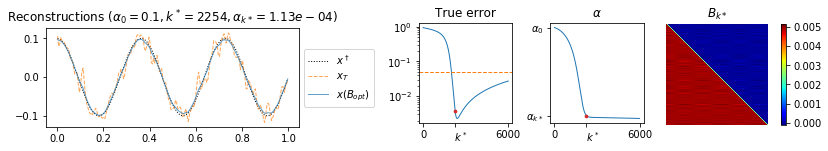

In [12]:
k = 2254
x_ref = tikhonov_l2(A, y_delta, summary1.alpha_seq[k])
plot_adaptive_alpha_l2(summary1,alpha0=1e-1, x_ref = x_ref, index=k)
# plt.savefig('adaptive_alpha_l2_1.pdf')

In [13]:
summary2 = adaptive_alpha_l2(alpha0=1e-2, lr=0.05, iters=6000)

alpha0=0.01,lr=0.05,iter=6000


standard tikhonov error: 0.023531329302982757
analytic deep prior error: 0.0026452678340869945


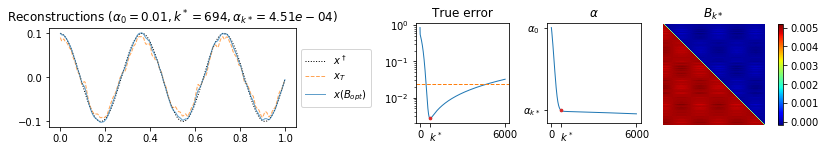

In [14]:
k=694
x_ref = tikhonov_l2(A, y_delta, summary2.alpha_seq[k])
plot_adaptive_alpha_l2(summary2, alpha0=1e-2, x_ref = x_ref, index=k)
# plt.savefig('adaptive_alpha_l2_2.pdf')

In [15]:
summary3 = adaptive_alpha_l2(alpha0=1e-3, lr=0.05, iters=6000)

alpha0=0.001,lr=0.05,iter=6000


standard tikhonov error: 0.02185863922874171
analytic deep prior error: 0.006373924393737879


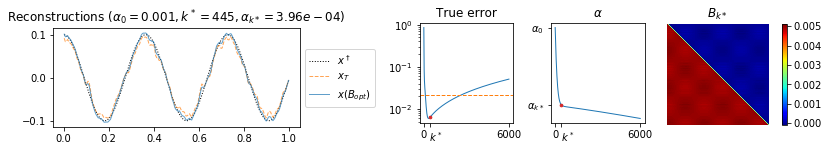

In [16]:
k=445
x_ref = tikhonov_l2(A, y_delta, summary3.alpha_seq[k])
plot_adaptive_alpha_l2(summary3, alpha0=1e-3, x_ref = x_ref, index=k)
# plt.savefig('adaptive_alpha_l2_3.pdf')

### Example (l1-regularization)
Now we consider a sparse $x^\dagger$.

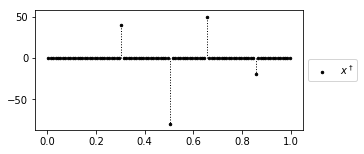

In [17]:
n=100
A, L, pts = get_operator('integral', n)

x_true = np.zeros(n).reshape(-1, 1)
x_true[30] = 40
x_true[50] = -80
x_true[65] = 50
x_true[85] = -20

fig = plt.figure(figsize=(6, 2.2))
ax = fig.add_subplot(1, 1, 1)
plot_true_solution(ax, pts, x_true, discrete_plot=True)

# plt.savefig('x_true_l1.pdf')

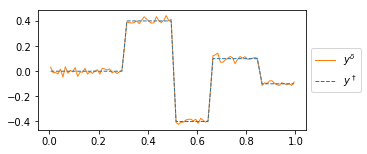

In [18]:
np.random.seed(1)

y_true = np.dot(A, x_true)
delta = 0.05 * np.max(np.abs(y_true))
y_delta = y_true + np.random.normal(0, delta, size=y_true.shape)

fig = plt.figure(figsize=(6, 2.2))
ax = fig.add_subplot(1, 1, 1)
plot_data(ax, pts, y_true, y_delta)

# plt.savefig('y_delta_l1.pdf')

#### Using a fixed value of $\alpha$

In [19]:
from solvers import tikhonov_l1

def fixed_alpha_l1(alpha, lr, iters):
    z = np.zeros(shape=x_true.shape)
    print('alpha={},lr={},iter={}'.format(alpha, lr, iters))

    x_tik = tikhonov_l1(A, y_delta, alpha)

    callback = Callback(x_true=x_true)
    x_deep = analytic_deep_prior(A, z=z, y_delta=y_delta, alpha=alpha, lam=1/L, layers=30, 
                                 train_alpha=False, iters=iters, lr=lr,
                                 callback=callback, callback_interval=10,
                                 pen='l1')

    print('standard tikhonov error: {}'.format(penalty(x_tik - x_true)))
    print('analytic deep prior error: {}'.format(penalty(x_deep - x_true)))
    
    plot_summary_fixed(pts, A, x_true=x_true, x_seq=callback.x_seq, x_ref=x_tik, B_seq=callback.B_seq, alpha=alpha,
                       discrete_plot=True)

alpha=0.005,lr=1e-05,iter=25000
standard tikhonov error: 452.4330227589531    
analytic deep prior error: 6.878929687286941


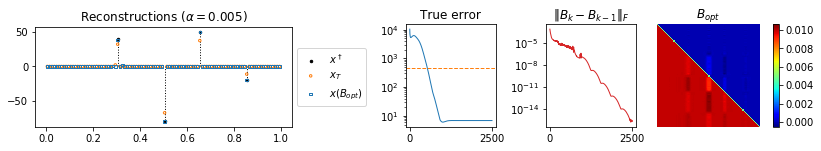

In [20]:
fixed_alpha_l1(alpha=5.0e-3, lr=1e-5, iters=25000)
# plt.savefig('fixed_alpha_l1_1.pdf')

alpha=0.001,lr=1e-05,iter=15000
standard tikhonov error: 21.024224589718315   
analytic deep prior error: 8.868658256194994


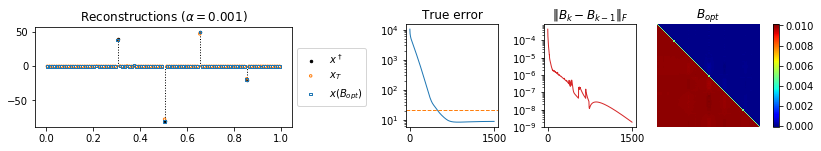

In [21]:
fixed_alpha_l1(alpha=1.0e-3, lr=1e-5, iters=15000)
# plt.savefig('fixed_alpha_l1_2.pdf')